### Importing Libraries and setting some global settings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import time
plt.rcParams['text.usetex'] = True

### The models
We will model the default intensity as a JCIR model and the interest rate as a Hull-White model.
JCIR:
$$d \lambda_t = \kappa(\mu_\lambda - \lambda_t) dt + v_\lambda\sqrt{\lambda_t}dZ_t + dJ_t ^{\alpha, \gamma} $$
Hull White:
$$dr_t = (\theta - \alpha r_t)dt + \sigma_t dW_t$$
for the sake of this demo file JCIR will be simulated using TJTW as in the second example in the JCIR file, and Hull-White will be modelled using the Euler-Marayuma model as demonstrated in it's file.

For demonstration there will be three runs, with $\rho = {0.8, 0, -0.8}$ to clearly show how we use different correlations and how the models behave under these conditions.

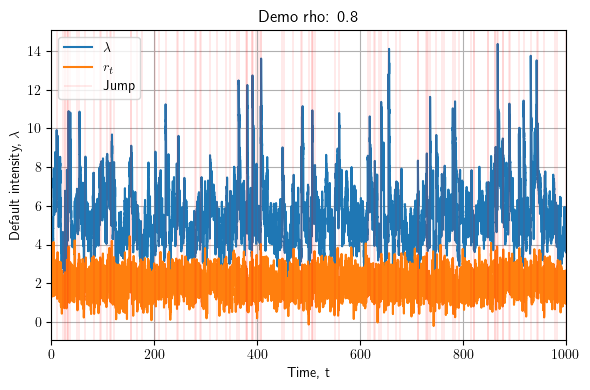

Correlation of output rho = 0.8: 0.445900814538209 


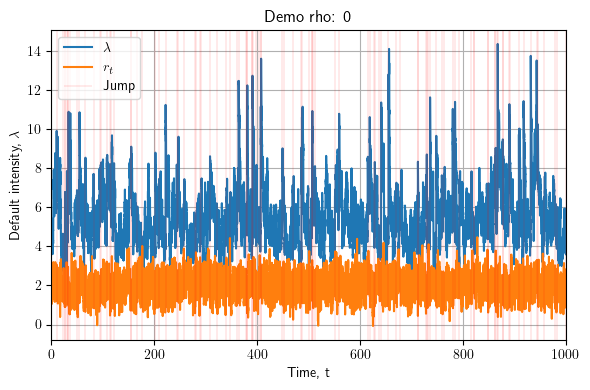

Correlation of output rho = 0: -0.036043880237936476 


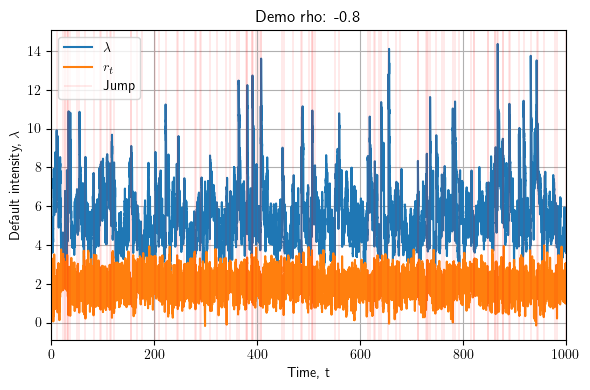

Correlation of output rho = 0: -0.44467820936650987


In [6]:
# Set parameters, for clarity those related to the JCIR model will be preceded by a J and those related to the Hull white by an H
t0 = 0
T = 1000

# Intensity params
j_lambda0 = 5
j_mu = 5
j_kappa = 0.5
j_v = 0.5

j_alpha = 100/T # We should expect to see about 100 jumps,
j_gamma = j_mu/2 # With expected size mu/5

# Short rate params
h_r0 = 2
h_theta = 5
h_alpha = 2.5
h_sigma = 1.25

rand = Generator(PCG64())

## Generate Jumps for the JCIR
jump_times = t0 + (T-t0)*rand.random(rand.poisson(j_alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(j_gamma) for a in jump_times] # Draws exponential intensities for each of the jumps

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run rho 0.8 diffusion model for let's say 25000 time steps over our 100 time units, i.e. dt = 1/25

N = 25000
t_s = np.linspace(t0,T,N)
t_s = np.concatenate((t_s,jump_times))
t_s.sort()
Y_s = np.linspace(np.sqrt(j_lambda0), np.sqrt(j_lambda0), len(t_s)) 
lambdas = np.linspace(j_lambda0, j_lambda0,len(t_s))
r = np.linspace(h_r0, h_r0,len(t_s))

# There ?might? be smarter ways to covary noise but I'm just generating them with constant corellation 0.8,
# for time varying we can generate in the for loop, or predraw all as here, but with varying rho
rho1 = 0.8
rho2 = 0
rho3 = -0.8
gen_noise = rand.multivariate_normal([0,0,0,0],[[1, rho1, rho2, rho3], [rho1, 1, rho2*rho1, rho3*rho1],[rho2, rho2*rho1, 1, rho3*rho2],[rho3, rho1*rho3, rho3*rho2, 1]],(len(t_s)))
Z_gen = gen_noise[:,0]
W_gen = gen_noise[:,1]

## Code duplication look away
W_genc0 = gen_noise[:,2]
W_gencn = gen_noise[:,3]
r_c0 = np.linspace(h_r0, h_r0,len(t_s))
r_cn = np.linspace(h_r0, h_r0,len(t_s))


for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*W_gen[i]
    dZ = np.sqrt(dt)*Z_gen[i]

    # Generate interest rate
    r[i] = r[i-1] + (h_theta-h_alpha*r[i-1])*dt + h_sigma*dW

    # Generate JCIR
    a = ((4*j_kappa*j_mu - j_v**2)*Y_s[i-1]**(-1) - (4*j_kappa)*Y_s[i-1])/8
    ap = (-(4*j_kappa*j_mu - j_v**2)*Y_s[i-1]**(-2) - (4*j_kappa))/8
    app = (4*j_kappa*j_mu - j_v**2)*Y_s[i-1]**(-3)/4
    b = (1/2)*j_v
    Y_s[i] = Y_s[i-1] + a*dt + b*dZ + (1/2)*(a*ap - (1/2)*app*b**2)*dt**2 + (1/2)*(ap*b)*dZ*dt
    lambdas[i] = Y_s[i]**2

    if not not jumps:
        if t_s[i] == jumps[0][0]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            Y_s[i] = np.sqrt(lambdas[i])
            jumps.pop(0)

    # Emergency negative catch
    if Y_s[i] < 0:
        Y_s[i] = 0


    # Generate 0 and negative corellation cases, this is sloppy code duplication so don't look at it or your eyes will bleed
    # Generate interest rate
    dWc0 = np.sqrt(dt)*W_genc0[i]
    dWcn = np.sqrt(dt)*W_gencn[i]
    r_c0[i] = r_c0[i-1] + (h_theta-h_alpha*r_c0[i-1])*dt + h_sigma*dWc0
    r_cn[i] = r_cn[i-1] + (h_theta-h_alpha*r_cn[i-1])*dt + h_sigma*dWcn



# Plot both to see that they move together :)
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas,label = r"$\lambda$")
ax1.plot(t_s,r,label = r"$r_t$")
ax1.set_title("Demo rho: %s" %(rho1))
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
lims = ax1.get_ylim()
ax1.vlines(jump_times,lims[0]-2,lims[1]+2,colors=('red',0.4),label="Jump",linestyles=['solid'],linewidth = 0.3)
ax1.legend()
ax1.set_ylim(lims)
plt.show()
print(r"Correlation of output rho = %s" %(rho1) + ": %s " %(np.corrcoef((lambdas,r))[0][1]))

# More ugly code duplication
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas,label = r"$\lambda$")
ax1.plot(t_s,r_c0,label = r"$r_t$")
ax1.set_title("Demo rho: %s" %(rho2))
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
lims = ax1.get_ylim()
ax1.vlines(jump_times,lims[0]-2,lims[1]+2,colors=('red',0.4),label="Jump",linestyles=['solid'],linewidth = 0.3)
ax1.legend()
ax1.set_ylim(lims)
plt.show()
print(r"Correlation of output rho = %s" %(rho2) + ": %s " %(np.corrcoef((lambdas,r_c0))[0][1]))

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas,label = r"$\lambda$")
ax1.plot(t_s,r_cn, label = r"$r_t$")
ax1.set_title("Demo rho: %s" %(rho3))
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
lims = ax1.get_ylim()
ax1.vlines(jump_times,lims[0]-2,lims[1]+2,colors=('red',0.4),label="Jump",linestyles=['solid'],linewidth = 0.3)
ax1.legend()
ax1.set_ylim(lims)
plt.show()
print(r"Correlation of output rho = %s" %(rho2) + ": %s" %(np.corrcoef((lambdas,r_cn))[0][1]))



### Brief Comments on the results
It is easy to see that including correlation between the driving processes to the interest rate and default intensity processes is essentialy trivial for our modelling methods, and there are other options we can use as well for instance the Cholesky decomposition if we want to manually introduce corellation to generated uncorrelated noise instead, and that these then filter to meaningful correlation in the output processes. 

Of note is that the more jumps you introduce to the JCIR process the less it's movement relates to the Hull-White process. Another interesting future investigation is to check the correlation between the default probability and the actual option value instead of these underlying functions. Thanks to monotonicity we can safely assume that it will exist, but the degree to which it is masked or exacerbated by the further dynamics can be interesting to see.